# HM2: Numerical Optimization for Logistic Regression

### Name: Tyler Bryk


# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to transform both training and test features

In [3]:
# Standardization

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.1211044   0.17350322 -0.03622868  0.02772706  0.05980291  0.19231926
   0.04332365  0.0571996 ]]
test std = 
[[0.94691883 0.96496835 1.09757817 1.10109863 1.07872359 1.00997121
  1.09632436 1.04333004]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization

    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5892603691483482
Objective value at t=2 is 0.5456502661822553
Objective value at t=3 is 0.5217322293599657
Objective value at t=4 is 0.5066061666689897
Objective value at t=5 is 0.4962610145863264
Objective value at t=6 is 0.4888358689675136
Objective value at t=7 is 0.48332927814685406
Objective value at t=8 is 0.4791467719690855
Objective value at t=9 is 0.4759108860684222
Objective value at t=10 is 0.4733701021183642
Objective value at t=11 is 0.4713506580138002
Objective value at t=12 is 0.4697290703929209
Objective value at t=13 is 0.46841555257241047
Objective value at t=14 is 0.46734355836857777
Objective value at t=15 is 0.4664629549784785
Objective value at t=16 is 0.4657354368632265
Objective value at t=17 is 0.46513137072818267
Objective value at t=18 is 0.46462758014828054
Objective value at t=19 is 0.46420576186388346
Objective value at t=20 is 0.4638513354727398
Objective value at t=21 is 0.463552595

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5357694975618597
Objective value at epoch t=1 is 0.5080102975490339
Objective value at epoch t=2 is 0.5006223496052009
Objective value at epoch t=3 is 0.5000954613200035
Objective value at epoch t=4 is 0.49364629434360374
Objective value at epoch t=5 is 0.49358141677101663
Objective value at epoch t=6 is 0.4816556298658142
Objective value at epoch t=7 is 0.4892093916574719
Objective value at epoch t=8 is 0.48450224496835154
Objective value at epoch t=9 is 0.4853082436062965
Objective value at epoch t=10 is 0.48050939130755044
Objective value at epoch t=11 is 0.4811783983194956
Objective value at epoch t=12 is 0.47764712808518517
Objective value at epoch t=13 is 0.4756250909515323
Objective value at epoch t=14 is 0.4766428344147403
Objective value at epoch t=15 is 0.47610099411039775
Objective value at epoch t=16 is 0.4730981186630756
Objective value at epoch t=17 is 0.4725759157962878
Objective value at epoch t=18 is 0.4720012731910995
Objective value 

# 4. Compare GD with SGD

Plot objective function values against epochs.

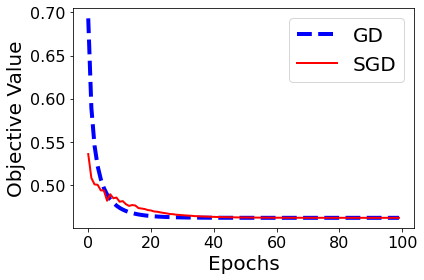

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2015625


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.28125


# 6. Mini-batch SGD



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [17]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    yx = numpy.multiply(yi, xi) # b-by-d matrix
    yxw = numpy.dot(yx, w) # b-by-1 matrix
    
    # calculate objective function Q_i
    log_loss = numpy.log(1 + numpy.exp(-yxw)) # b-by-1 matrix
    loss = numpy.mean(log_loss) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    mat1 = numpy.divide(yx, 1+numpy.exp(yxw)) # b-by-d matrix
    mat2 = -numpy.mean(mat1, axis=0).reshape(d, 1) # d-by-1 matrix
    g = mat2 + lam * w # d-by-1 matrix
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [18]:
# Helper Function for Dividing (X,Y) into B-batches
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     b: integer, the batch size
# Return:
#     batches: Array of B samples containing (X,Y)
def make_batches(x, y, b): 
    batches = [] 
    data = numpy.hstack((x, y)) 
    n_batches = data.shape[0] // b 
    for i in range(n_batches): 
        batch = data[i*b:(i+1)*b, :] 
        xb = batch[:, :-1] 
        yb = batch[:, -1]
        batches.append((xb, yb)) 
    return batches 

In [19]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        batches = make_batches(x_rand, y_rand, b) 
        for batch in batches:
            xb, yb = batch
            obj, g = mb_stochastic_objective_gradient(w, xb, yb, lam, b)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9
        objval /= (n/b)
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))    
    
    return w, objvals

## 6.3. Run MB-SGD

In [20]:
# MB-SGD with batch size b=8
lam = 1E-6
b = 8
stepsize = 0.1
w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5398420855276751
Objective value at epoch t=1 is 0.479344835170718
Objective value at epoch t=2 is 0.47156282156839086
Objective value at epoch t=3 is 0.4695287751006389
Objective value at epoch t=4 is 0.4675221607696485
Objective value at epoch t=5 is 0.46712979834421436
Objective value at epoch t=6 is 0.4663896750828365
Objective value at epoch t=7 is 0.46610678840153746
Objective value at epoch t=8 is 0.465414083833784
Objective value at epoch t=9 is 0.46526689688243617
Objective value at epoch t=10 is 0.46498558404428775
Objective value at epoch t=11 is 0.4645790595651954
Objective value at epoch t=12 is 0.4642971825756249
Objective value at epoch t=13 is 0.46412589500891344
Objective value at epoch t=14 is 0.4640145647708113
Objective value at epoch t=15 is 0.4637490199315205
Objective value at epoch t=16 is 0.4636486747558237
Objective value at epoch t=17 is 0.46336842810633694
Objective value at epoch t=18 is 0.4632389772531999
Objective value a

In [21]:
# MB-SGD with batch size b=64
lam = 1E-6
b = 64
stepsize = 0.8
w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5379858848867717
Objective value at epoch t=1 is 0.47962466871094145
Objective value at epoch t=2 is 0.47058182878110755
Objective value at epoch t=3 is 0.4687110491838865
Objective value at epoch t=4 is 0.468179305358383
Objective value at epoch t=5 is 0.46639378400116643
Objective value at epoch t=6 is 0.46552999418763685
Objective value at epoch t=7 is 0.46624675121387565
Objective value at epoch t=8 is 0.46498214731665993
Objective value at epoch t=9 is 0.4646455891760401
Objective value at epoch t=10 is 0.464861034704235
Objective value at epoch t=11 is 0.4647539041118144
Objective value at epoch t=12 is 0.4636734744645826
Objective value at epoch t=13 is 0.4640436265057578
Objective value at epoch t=14 is 0.46363602061704573
Objective value at epoch t=15 is 0.463128162031927
Objective value at epoch t=16 is 0.4640285925347736
Objective value at epoch t=17 is 0.46297893910883275
Objective value at epoch t=18 is 0.46293652341189817
Objective value 

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

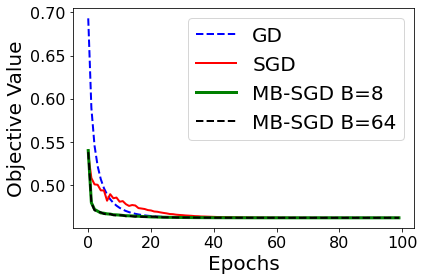

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig2 = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mgd8 = range(len(objvals_mbsgd8))
epochs_mgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=2)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(epochs_mgd8, objvals_mbsgd8, '-g', LineWidth=3)
line3, = plt.plot(epochs_mgd64, objvals_mbsgd64, '--k', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MB-SGD B=8', 'MB-SGD B=64'], fontsize=20)
plt.tight_layout()
plt.show()
fig2.savefig('compare_gd_sgd_mbgd8_mbgd64.pdf', format='pdf', dpi=1200)